# Install all kinds of requirements

In [1]:
!apt install libglfw3-dev -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglfw3-dev is already the newest version (3.3.6-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [2]:
from IPython.display import HTML, clear_output

%pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
%pip install matplotlib
%pip install IPython
%pip install flax
clear_output()

import functools
import os
from datetime import datetime

import jax
import matplotlib.pyplot as plt
from jax import numpy as jp

try:
    import brax
except ImportError:
    %pip install git+https://github.com/google/brax.git@main
    clear_output()
    import brax

import flax
from brax import envs
from brax import geometry as braxgeo
from brax.io import html, json, model
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

## Double check GPU

In [3]:
!nvidia-smi

Sun May 14 04:22:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   43C    P8               28W / 420W|      1MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Train the agent on the base reward

In [4]:
env = envs.create(env_name="ant", backend="positional")

In [5]:
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

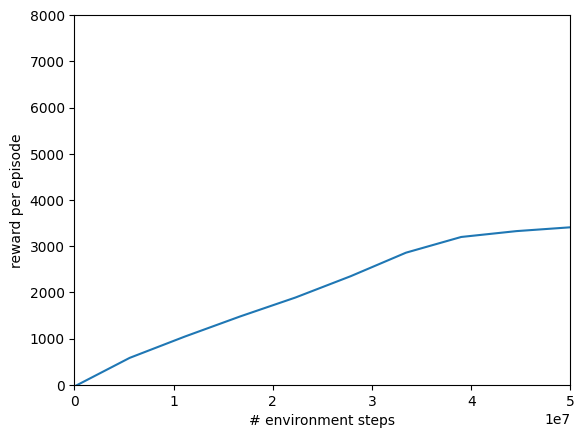

time to jit: 0:00:32.012714
time to train: 0:03:07.666516


In [6]:
max_y = 8000
min_y = 0

xdata, ydata = [], []
times = [datetime.now()]


def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics["eval/episode_reward"])
    clear_output(wait=True)
    plt.xlim([0, 50_000_000])
    plt.ylim([min_y, max_y])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.plot(xdata, ydata)
    plt.show()


make_inference_fn, params, _ = ppo.train(
    environment=env,
    progress_fn=progress,
    num_timesteps=50_000_000,
    num_evals=10,
    reward_scaling=10,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=5,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=4096,
    batch_size=2048,
    seed=1,
)


print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [7]:
model.save_params("/tmp/params", params)
params = model.load_params("/tmp/params")
inference_fn = make_inference_fn(params)

## Visualize

In [8]:
# @title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name="ant", backend="positional")

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_env_step(state, act)

HTML(html.render(env.sys.replace(dt=env.dt), rollout))

# Make the other reward functions

In [9]:
@jax.jit
def flying_reward(state: envs.State, action: jax.Array) -> jax.Array:
    contact = braxgeo.contact(  # type: brax.base.Contact
        state.pipeline_state.s, state.pipeline_state.x  # type: ignore
    )

    num_contacts = contact.link_idx[0].shape[0]  # type: ignore

    return state.reward + num_contacts * -0.25

In [10]:
@jax.jit
def lazy_reward(state: envs.State, action: jax.Array) -> jax.Array:
    movement = jp.linalg.norm(action, axis=-1)

    return state.reward + movement * -0.5

In [11]:
@jax.jit
def steady_reward(state: envs.State, action: jax.Array) -> jax.Array:
    body_y_vel = state.pipeline_state.xd.vel[0]  # type: ignore

    return state.reward + body_y_vel**2 * -0.5

In [12]:
@jax.jit
def tall_reward(state: envs.State, action: jax.Array) -> jax.Array:
    z_height = state.pipeline_state.x.pos[0][2]  # type: ignore

    return state.reward + z_height * 0.25

## Add reward functions to reward_flavors array

In [13]:
reward_flavors = [flying_reward, lazy_reward, steady_reward, tall_reward]

# Collecting Rollouts to Rank

In [14]:
env = envs.create(env_name="ant", backend="positional")

jit_vec_env_reset = jax.jit(env.reset)
jit_vec_env_step = jax.jit(env.step)

rollouts = []
rng = jax.random.PRNGKey(seed=1)
states = jit_env_reset(rng=rng)

parallel_envs = 1024
num_rollouts = 4096
trajectory_length = 1000

In [15]:
vmapped_reset = jax.vmap(jit_env_reset)
vmapped_step = jax.vmap(jit_env_step)
vmapped_inference_fn = jax.vmap(jit_inference_fn)

In [16]:
@jax.jit
def collect_rollout(
    rng: jax.Array
):
    rng, reset_rng = jax.random.split(rng)
    initial_state = jax.jit(env.reset)(rng=reset_rng)

    def scan_fn(state, rng):
        acts, _ = inference_fn(states.obs, rng)
        return jax.jit(env.step)(state, acts), (states, acts)

    rng, scan_rng = jax.random.split(rng)
    final_state, rollout = jax.lax.scan(
        f=scan_fn,
        init=initial_state,
        xs=jax.random.split(scan_rng, trajectory_length),
    )

    return rollout

In [17]:
rollout_batches = []

for _ in range(num_rollouts // parallel_envs):
    rng, rollout_rng = jax.random.split(rng)
    rollout_rngs = jax.random.split(rollout_rng, parallel_envs)
    new_rollouts = jax.vmap(collect_rollout)(rollout_rngs)
    # print("rollout batch collected")
    new_rollouts = jax.device_put(new_rollouts, jax.devices("cpu")[0])
    rollout_batches.append(new_rollouts)

## Concatenate together parallel rollouts

In [23]:
rollouts = jax.tree_map(lambda *x: jp.concatenate(x), *rollout_batches)

: 

: 

In [25]:
for reward_flavor in reward_flavors:
    
    def trajectory_reward(state: envs.State, action: jax.Array):
        jax.lax.reduce(jax.vmap(reward_flavor)(state, action), 0, lambda a, b: a + b)
    
    all_rewards = jax.vmap(trajectory_reward)(*all_rollouts)
    print(f"{reward_flavor.__name__}: {all_rewards.mean()}")

AttributeError: 'NoneType' object has no attribute 'link_idx'